# Projet 4 - Segmentation des clients d'un site e-commerce

## Analyse exploratoire et création d'un dataset clean

Le but de ce notebook est d'analyser le jeu de données initial et de le traiter afin de produire un dataset "clean", exporté en csv, qui sera la base du travail de machine learning consécutif.

### Table des matières
1. [Importation et préparation des données](#1-importation-et-préparation-des-données)
2. [Analyse des données manquantes](#2-analyse-des-données-manquantes)
3. [Analyse des variables numériques](#3-analyse-des-variables-numériques)
4. [Analyse des variables catégorielles](#4-analyse-des-variables-catégorielles)
5. [Analyse des corrélations](#5-analyse-des-corrélations)
6. [Feature Engineering](#6-feature-engineering)
7. [Traitement des outliers](#7-traitement-des-outliers)
8. [Préparation du dataset final](#8-préparation-du-dataset-final)
9. [Conclusion et prochaines étapes](#9-conclusion-et-prochaines-étapes)

### Imports et paramètres

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from MLUtils import DataAnalysis, DataEngineering

import warnings
warnings.filterwarnings("ignore")

# Pour une meilleure lisibilité des graphiques
plt.style.use('ggplot')  # Utilisation d'un style valide de matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

# Configuration de seaborn pour une meilleure esthétique
sns.set_theme(style="whitegrid")

## 1. Importation et préparation des données

In [2]:
# Importation du jeu de données
df = pd.read_csv('data/customer_segments3_202409201627.csv')
print(f"Le jeu initial de données contient {df.shape[0]} observations réparties en {df.shape[1]} colonnes/variables.")
df.info()

Le jeu initial de données contient 97078 observations réparties en 13 colonnes/variables.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97078 entries, 0 to 97077
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         97078 non-null  object 
 1   total_orders               97078 non-null  int64  
 2   avg_delivery_time_days     94892 non-null  float64
 3   last_order_date            97078 non-null  object 
 4   days_since_last_order      97078 non-null  float64
 5   total_spent                97078 non-null  float64
 6   avg_review_score           96353 non-null  float64
 7   avg_delivery_delay_days    97078 non-null  float64
 8   max_delivery_delay_days    97078 non-null  float64
 9   last_order_status          97078 non-null  object 
 10  has_comment                97078 non-null  int64  
 11  last_payment_type          97077 non-null  object 
 12  last_payment

In [3]:
df.sample(10)

,customer_unique_id,total_orders,avg_delivery_time_days,last_order_date,days_since_last_order,total_spent,avg_review_score,avg_delivery_delay_days,max_delivery_delay_days,last_order_status,has_comment,last_payment_type,last_payment_installments
80083,d2da929fa57473521f1f3b9146916122,1,9.391042,2017-08-28 10:39:52,415.326690,56.69,5.0,0.0,0.0,delivered,0,credit_card,4.0
2658,070742717e9b0a917f0823213f3669b2,1,20.299769,2017-10-03 10:30:22,379.333287,85.14,5.0,0.0,0.0,delivered,0,boleto,1.0
88230,e8601415b6a6268b60b06ed032d8f546,1,16.973600,2017-05-30 16:20:28,505.090162,97.20,3.0,0.0,0.0,delivered,1,boleto,1.0
23085,3cbe83af0cacebaba139458a9207da34,1,8.078287,2018-04-18 16:20:07,182.090405,192.04,5.0,0.0,0.0,delivered,0,credit_card,3.0
23021,3c8b66dcc7c613938aa90c8d844b98a0,1,9.089132,2017-07-08 19:09:56,465.972477,359.19,4.0,0.0,0.0,delivered,1,credit_card,6.0
89336,eb48ffba67cba28517bb674db18f065f,1,8.423819,2018-08-22 10:28:17,56.334734,161.79,5.0,0.0,0.0,delivered,1,credit_card,3.0
88164,e835ab99ba29adadc849075eb03cb60f,1,7.897373,2017-12-05 17:11:39,316.054618,39.84,5.0,0.0,0.0,delivered,0,credit_card,3.0
32392,5538f4cb054b71b5525a019a47019aa0,1,13.922662,2018-08-14 23:23:38,63.796296,202.82,4.0,0.0,0.0,delivered,0,credit_card,4.0
44469,750550f1fbf777d9383acb856bc593dd,1,6.806887,2018-02-18 16:36:52,241.078773,196.46,3.0,0.0,0.0,delivered,1,credit_card,2.0
23347,3d7201a23fdbd167157b7abd027f92a7,1,5.754028,2018-08-19 22:58:44,58.813588,50.35,5.0,0.0,0.0,delivered,0,boleto,1.0


In [4]:
# 6. Feature Engineering

# 1. Calcul du ratio de dépense moyenne par commande
df['avg_spent_per_order'] = df['total_spent'] / df['total_orders']

# 2. Calcul de l'intervalle moyen entre commandes (en jours)
# Pour les clients ayant plus d'une commande, on estime l'intervalle moyen en divisant
# le nombre de jours depuis la dernière commande par (total_orders - 1).
# Pour les clients avec une seule commande, on utilise le nombre de jours depuis la dernière commande
df['avg_days_between_orders'] = df.apply(
    lambda row: row['days_since_last_order'] / (row['total_orders'] - 1) if row['total_orders'] > 1 else np.nan,
    axis=1
)
df['avg_days_between_orders'].fillna(df['days_since_last_order'], inplace=True)

# 3. Calcul d'un score de fidélité combiné
# Un score plus élevé indique un client dépensant beaucoup par commande et passant peu de temps entre ses commandes
df['loyalty_score'] = df['avg_spent_per_order'] / (df['avg_days_between_orders'] + 1)

# 4. Créer une variable binaire pour le type de paiement (1 pour carte de crédit, 0 pour les autres)
df['is_credit_card'] = df['last_payment_type'].apply(lambda x: 1 if x == 'credit_card' else 0)

# 5. Créer une variable pour la récence (plus la valeur est faible, plus le client est récent)
df['recency_score'] = df['days_since_last_order'].rank(pct=True)

# 6. Créer une variable pour la fréquence (inversée par rapport à avg_days_between_orders)
df['frequency_score'] = 1 / (df['avg_days_between_orders'] + 1)

# Affichage des nouvelles variables
print("Aperçu des variables créées par feature engineering:")
display(df[['avg_spent_per_order', 'avg_days_between_orders', 'loyalty_score', 
         'is_credit_card', 'recency_score', 'frequency_score']].head())

Aperçu des variables créées par feature engineering:


,avg_spent_per_order,avg_days_between_orders,loyalty_score,is_credit_card,recency_score,frequency_score
0,141.90,160.315174,0.879644,1,0.236253,0.006199
1,27.19,163.304757,0.165485,1,0.246802,0.006086
2,86.22,585.892535,0.146909,1,0.963514,0.001704
3,43.62,369.917095,0.117600,1,0.708193,0.002696
4,196.89,336.947639,0.582605,1,0.657780,0.002959


## 2. Analyse des données manquantes

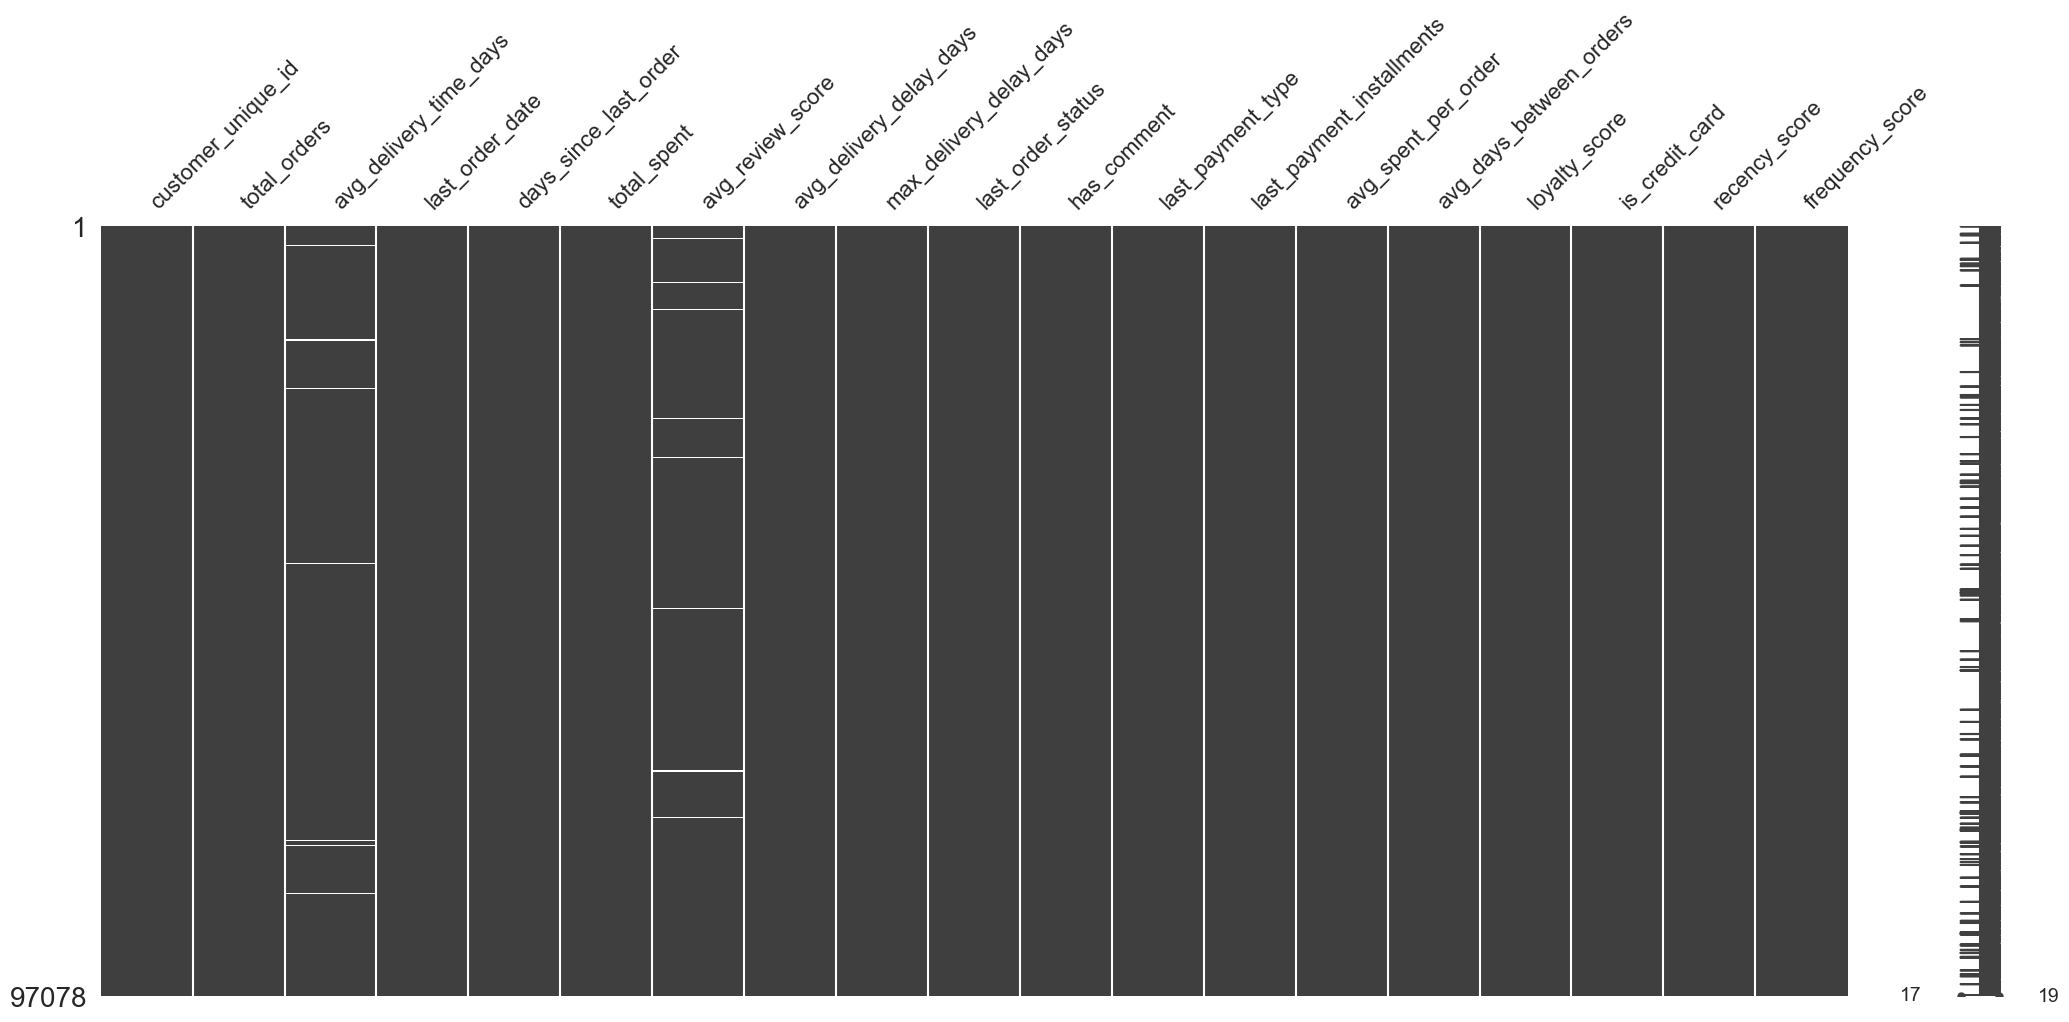

In [5]:
DataAnalysis.show_columns_population(df, 'matrix')

In [6]:
df.sample(10)

,customer_unique_id,total_orders,avg_delivery_time_days,last_order_date,days_since_last_order,total_spent,avg_review_score,avg_delivery_delay_days,max_delivery_delay_days,last_order_status,has_comment,last_payment_type,last_payment_installments,avg_spent_per_order,avg_days_between_orders,loyalty_score,is_credit_card,recency_score,frequency_score
53486,8d4c7f9a1523ad5f2db9e08cb4f43bd3,1,21.463426,2018-03-05 12:37:23,226.245081,235.28,5.0,0.000000,0.000000,delivered,0,credit_card,2.0,235.280,226.245081,1.035358,1,0.395981,0.004401
21084,376c9c37aea85ca26315dfe54b3e4c93,1,3.089456,2017-08-27 16:14:04,416.094606,350.19,4.0,0.000000,0.000000,delivered,0,credit_card,7.0,350.190,416.094606,0.839594,1,0.775418,0.002398
13360,231affe4b855d6636825f11617b621dd,1,12.218426,2018-04-13 16:19:29,187.090845,48.22,3.0,0.000000,0.000000,delivered,1,voucher,1.0,48.220,187.090845,0.256365,0,0.304240,0.005317
23299,3d540559ce0677a17f45eab0cb113c8d,1,37.092384,2017-07-10 17:44:36,464.031736,1442.84,4.0,7.831690,7.831690,delivered,1,boleto,1.0,1442.840,464.031736,3.102670,0,0.840716,0.002150
25144,423ddcb7c0603e732d87bcc5c87eab9c,1,26.903773,2018-04-05 17:25:17,195.045150,54.22,1.0,0.629664,0.629664,delivered,0,credit_card,1.0,54.220,195.045150,0.276569,1,0.321916,0.005101
69788,b7d4cab5dd11b238da97b01eaf657293,1,2.565174,2017-08-16 02:00:10,427.687593,62.66,5.0,0.000000,0.000000,delivered,1,credit_card,6.0,62.660,427.687593,0.146167,1,0.790364,0.002333
43181,71a26c172a544ccc789674f1fab9d951,2,10.517911,2018-04-13 13:45:45,187.197604,238.79,5.0,0.000000,0.000000,delivered,1,voucher,1.0,119.395,187.197604,0.634413,0,0.304590,0.005314
20062,34b6d5afbfbe25fc4fdbf0309b8aeec1,1,13.081493,2018-03-20 16:48:24,211.070764,43.22,5.0,0.000000,0.000000,delivered,0,credit_card,4.0,43.220,211.070764,0.203800,1,0.359093,0.004715
60651,9fb605ad4f0d32457f99def33e7fd10d,1,5.963715,2018-06-28 13:20:09,111.215382,157.11,5.0,0.000000,0.000000,delivered,1,credit_card,10.0,157.110,111.215382,1.400075,1,0.134706,0.008911
45210,770d94a0be6e9d8f5ecf5ab0ae8a2c03,1,12.056516,2018-01-20 16:00:29,270.104039,175.08,5.0,0.000000,0.000000,delivered,0,credit_card,3.0,175.080,270.104039,0.645804,1,0.500433,0.003689


In [7]:
# On supprime la colonne "last_order_date" car elle ne nous sera pas utile, nous avons déjà la colonne "days_since_last_order"
df = df.drop(columns=['last_order_date'])

# On supprime les observations avec des valeurs manquantes
df = df.dropna()
print(f"Après suppression des valeurs manquantes, nous avons {df.shape[0]} observations utilisables.")

Après suppression des valeurs manquantes, nous avons 94269 observations utilisables.


## 3. Analyse des variables numériques

In [8]:
# Sélection des colonnes numériques
numeric_columns = df.select_dtypes(include=['number']).columns
print("Colonnes numériques :")
print(numeric_columns)

# Statistiques descriptives
df[numeric_columns].describe()

Colonnes numériques :
Index(['total_orders', 'avg_delivery_time_days', 'days_since_last_order',
       'total_spent', 'avg_review_score', 'avg_delivery_delay_days',
       'max_delivery_delay_days', 'has_comment', 'last_payment_installments',
       'avg_spent_per_order', 'avg_days_between_orders', 'loyalty_score',
       'is_credit_card', 'recency_score', 'frequency_score'],
      dtype='object')


,total_orders,avg_delivery_time_days,days_since_last_order,total_spent,avg_review_score,avg_delivery_delay_days,max_delivery_delay_days,has_comment,last_payment_installments,avg_spent_per_order,avg_days_between_orders,loyalty_score,is_credit_card,recency_score,frequency_score
count,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000,94269.000000
mean,1.016739,12.519144,287.770761,162.969419,4.155474,0.757350,0.765609,0.408119,2.928248,160.255285,287.611113,0.808078,0.771972,0.497931,0.005039
std,0.142699,9.462724,152.802708,223.318382,1.282087,4.673798,4.695404,0.491488,2.708299,218.177023,152.806415,1.477122,0.419563,0.288410,0.003689
min,1.000000,0.533414,49.145613,9.590000,1.000000,0.000000,0.000000,0.000000,0.000000,9.590000,5.796935,0.023585,0.000000,0.000021,0.001342
25%,1.000000,6.765856,163.737350,62.540000,4.000000,0.000000,0.000000,0.000000,1.000000,62.170000,163.354329,0.214689,1.000000,0.247512,0.002512
50%,1.000000,10.210301,268.780012,106.720000,5.000000,0.000000,0.000000,0.000000,2.000000,105.560000,268.339549,0.422863,1.000000,0.497528,0.003713
75%,1.000000,15.671852,397.218368,179.340000,5.000000,0.000000,0.000000,1.000000,4.000000,176.870000,397.123634,0.859718,1.000000,0.747461,0.006084
max,11.000000,208.351759,744.364907,13664.080000,5.000000,188.975081,188.975081,1.000000,24.000000,13664.080000,744.364907,76.454415,1.000000,0.999959,0.147125


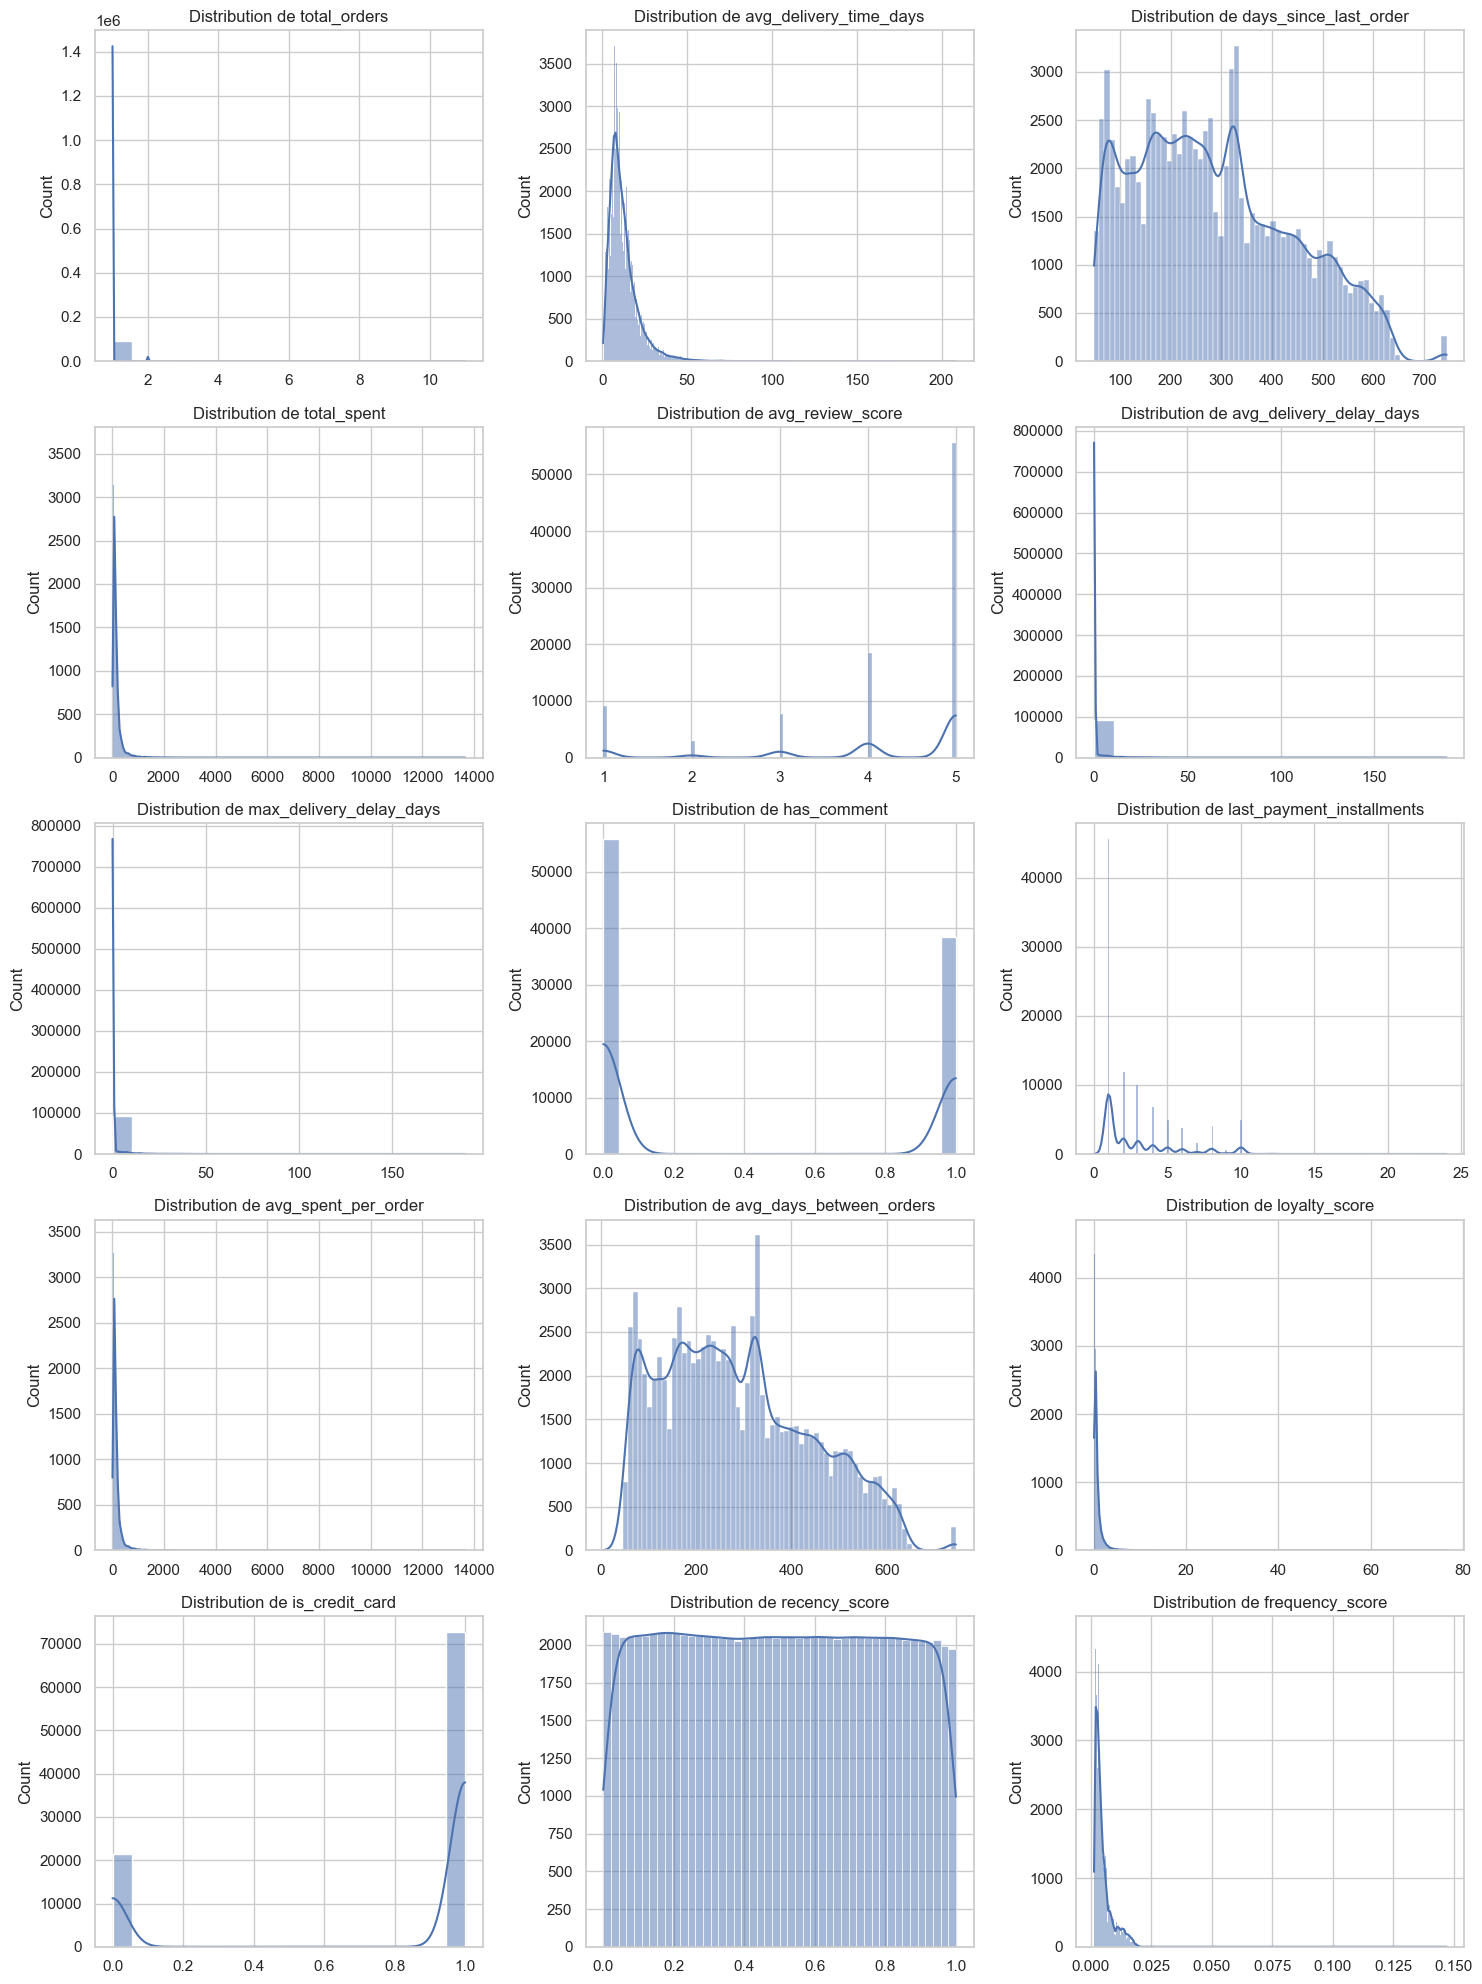

In [9]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Nombre total de graphiques à tracer
num_plots = len(numeric_columns)
# Définir le nombre de colonnes souhaité, par exemple 3
num_cols = 3
# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
axes = axes.flatten()  # Mettre tous les axes dans un tableau 1D

for idx, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution de {col}')
    axes[idx].set_xlabel('')

# Supprimer les axes inutilisés
for ax in axes[num_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [10]:
def remove_outliers(df, column):
	# Calcul des quartiles et de l'IQR
	Q1 = df[column].quantile(0.25)
	Q3 = df[column].quantile(0.75)
	IQR = Q3 - Q1

	# Définition des bornes
	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR
	
	# Filtrer le DataFrame
	initial_count = len(df)
	filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
	removed_count = initial_count - len(filtered_df)
	
	# Affichage des informations
	print(f"Colonne '{column}' : {removed_count} outliers supprimés.")
	print(f"Nouvelles limites : lower_bound = {lower_bound:.2f}, upper_bound = {upper_bound:.2f}")
	
	return filtered_df

In [11]:
# 7. Traitement des outliers

# Fonction pour identifier et supprimer les outliers avec la méthode IQR
def remove_outliers(df, column):
    # Calcul des quartiles et de l'IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Définition des bornes
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrer le DataFrame
    initial_count = len(df)
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    removed_count = initial_count - len(filtered_df)
    
    # Affichage des informations
    print(f"Colonne '{column}' : {removed_count} outliers supprimés ({removed_count/initial_count*100:.2f}%).")
    print(f"Nouvelles limites : lower_bound = {lower_bound:.2f}, upper_bound = {upper_bound:.2f}")
    
    return filtered_df

# Appliquer la suppression des outliers aux colonnes numériques pertinentes
print("Suppression des outliers sur les variables clés...")
df = remove_outliers(df, 'avg_delivery_time_days')
df = remove_outliers(df, 'last_payment_installments')
df = remove_outliers(df, 'avg_spent_per_order')
df = remove_outliers(df, 'loyalty_score')

print(f"\nAprès suppression des outliers, nous avons {df.shape[0]} observations utilisables.")

Suppression des outliers sur les variables clés...
Colonne 'avg_delivery_time_days' : 4779 outliers supprimés (5.07%).
Nouvelles limites : lower_bound = -6.59, upper_bound = 29.03
Colonne 'last_payment_installments' : 5487 outliers supprimés (6.13%).
Nouvelles limites : lower_bound = -3.50, upper_bound = 8.50
Colonne 'avg_spent_per_order' : 5885 outliers supprimés (7.01%).
Nouvelles limites : lower_bound = -100.06, upper_bound = 324.04
Colonne 'loyalty_score' : 5805 outliers supprimés (7.43%).
Nouvelles limites : lower_bound = -0.56, upper_bound = 1.46

Après suppression des outliers, nous avons 72313 observations utilisables.


# Analyse de la colonne 'total_orders'

In [12]:
# Trouver les valeurs différentes et le count pour chacun d'elle pour cette colonne
#df['total_orders'].value_counts()

Nous constatons que la plupart des clients ont fait une seule commande. Nous allons donc classer les clients en deux buckets : 
- ceux qui ont fait une seule commande
- ceux qui ont fait plus d'une commande

In [13]:
# # Créer une colonne "only_one_order" qui sera à 1 si le client n'a passé qu'une seule commande, 0 sinon
# df['more_than_one_order'] = df['total_orders'].apply(lambda x: 0 if x == 1 else 1)

# # On peut alors drop la colonne "total_orders"
# df = df.drop(columns=['total_orders'])

# # Enlever 'total_order' de numeric_columns
# numeric_columns = numeric_columns.drop('total_orders')
# # Ajouter 'only_one_order' à numeric_columns
# numeric_columns = numeric_columns.insert(0, 'more_than_one_order')

# Analyse de la colonne 'avg_delivery_time_days'

On constate sur le graphique de répartition de cette colonne que la courbe est bien lisse pour les valeurs inférieures à 70 jours. Nous allons donc éliminer les valeurs supérieures à 70 jours qui sont des outliers.

In [14]:
# Enlever les lignes avec des valeurs supérieures à 70 pour la colonne 'avg_delivery_time_days'
# df = df[df['avg_delivery_time_days'] <= 70]

# Analyse de la colonne 'days_since_last_order'

On constate sur le graphique de répartition de cette colonne que la courbe est bien lisse pour les valeurs inférieures à 650 jours. Nous allons donc éliminer les valeurs supérieures à 650 jours qui sont des outliers.

In [15]:
# Enlever les lignes avec des valeurs supérieures à 70 pour la colonne 'days_since_last_order'
# df = df[df['days_since_last_order'] <= 650]

# Analyse de la colonne 'total_spent'

On constate sur le graphique de répartition de cette colonne que la courbe est bien lisse pour les valeurs inférieures à 1000. Nous allons donc éliminer les valeurs supérieures à 1000 qui sont des outliers.

In [16]:
# Enlever les lignes avec des valeurs supérieures à 1000 pour la colonne 'total_spent'
# df = df[df['total_spent'] <= 1000]

# Voyons si nos graphes sont plus précis et exploitable maintenant que les outliers ont été enlevés

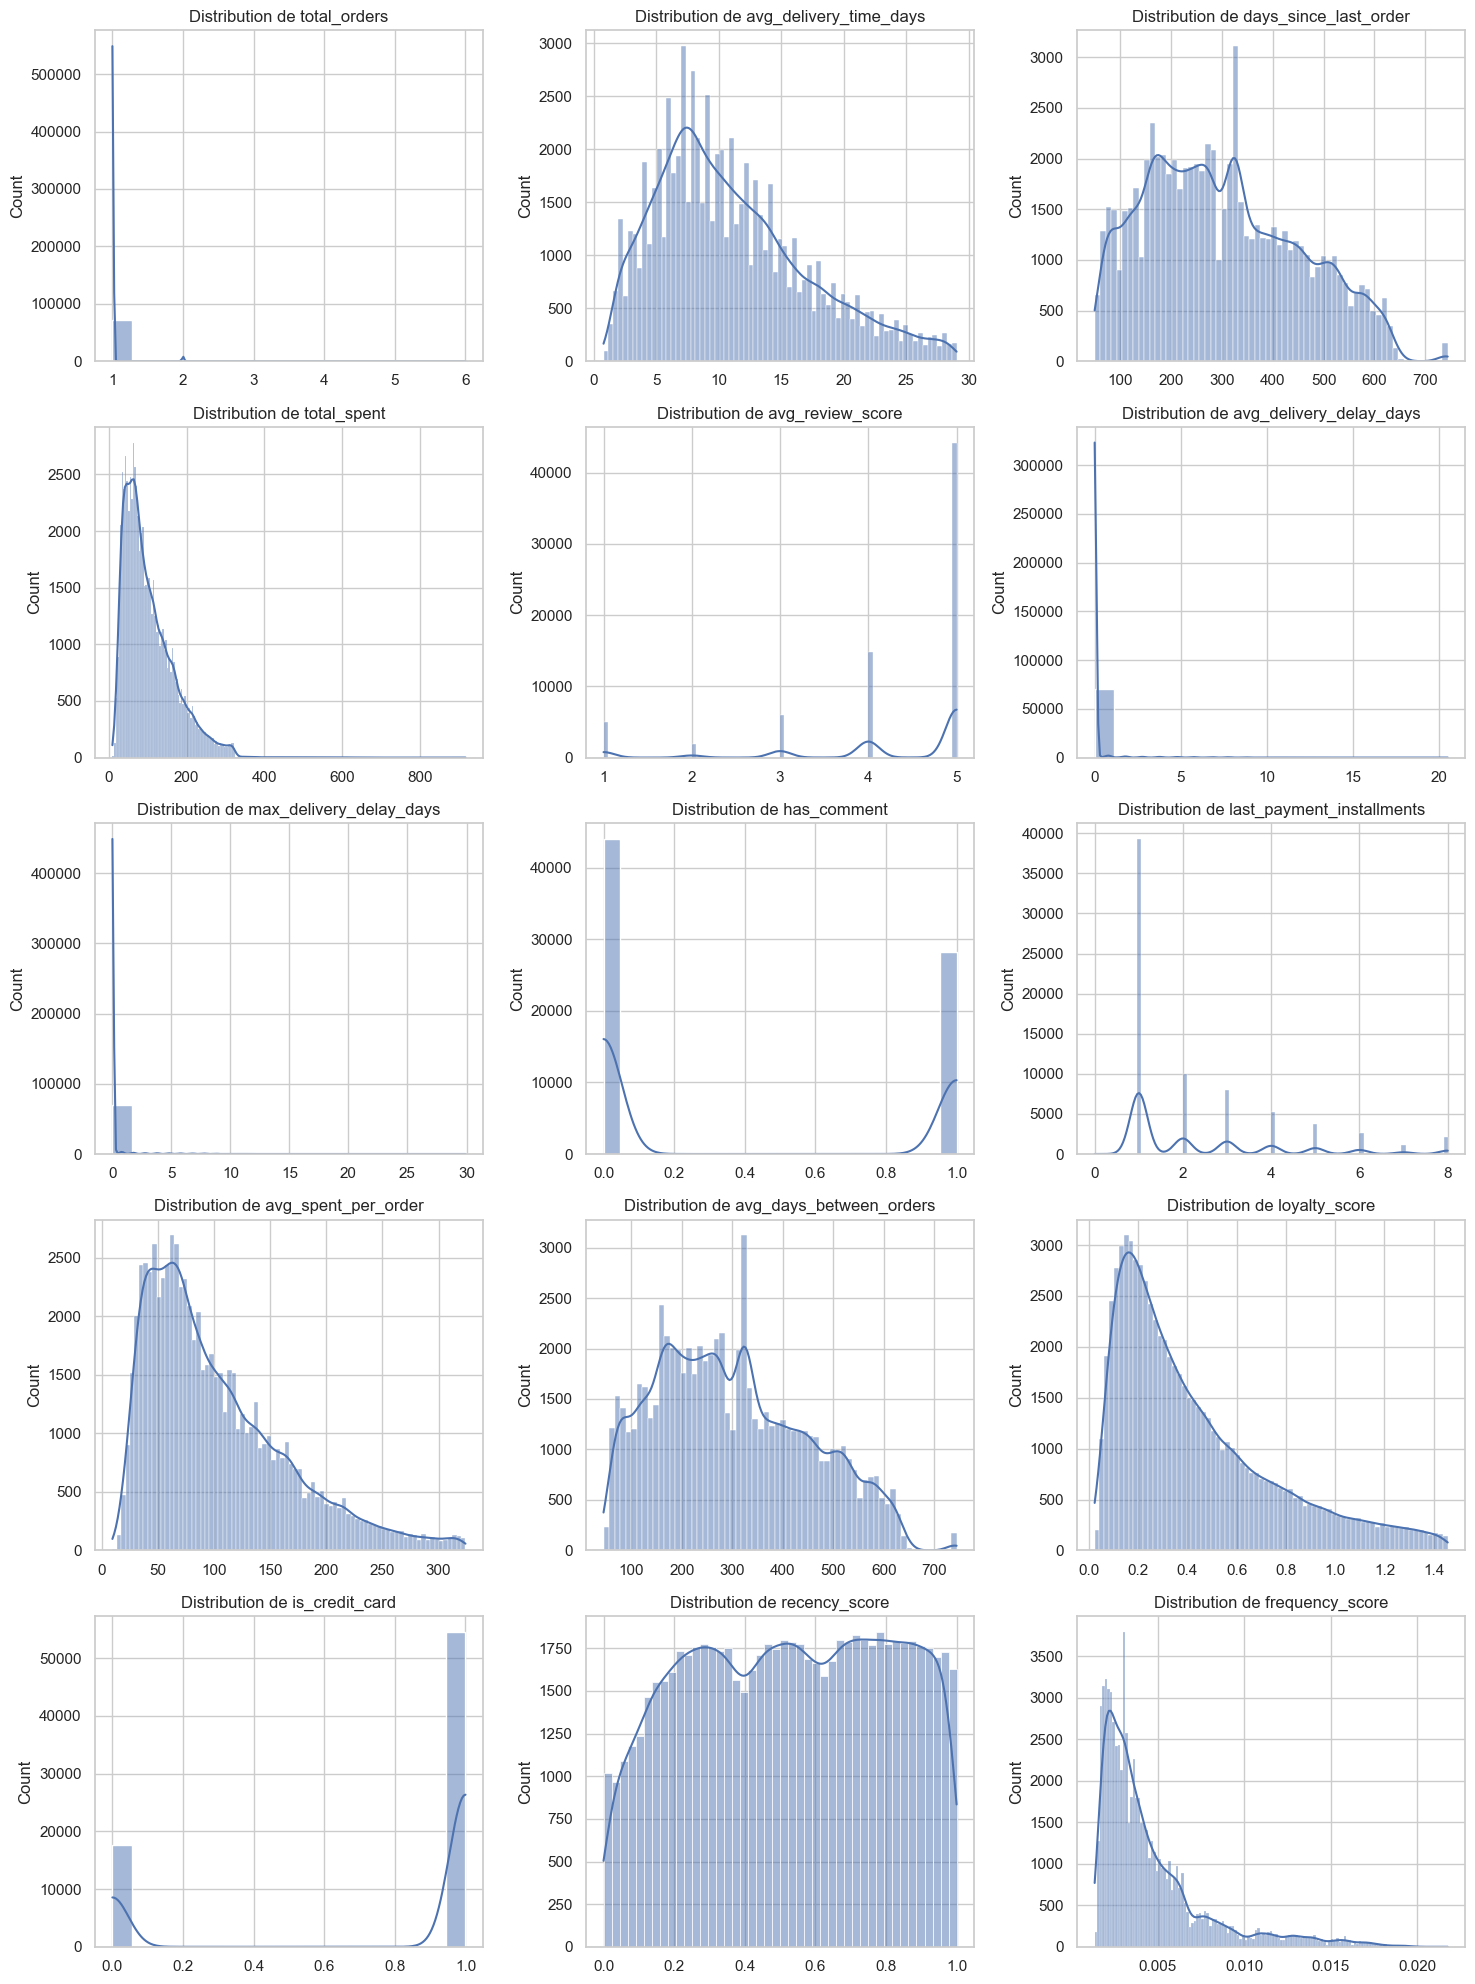

In [17]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Nombre total de graphiques à tracer
num_plots = len(numeric_columns)
# Définir le nombre de colonnes souhaité, par exemple 3
num_cols = 3
# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
axes = axes.flatten()  # Mettre tous les axes dans un tableau 1D

for idx, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution de {col}')
    axes[idx].set_xlabel('')

# Supprimer les axes inutilisés
for ax in axes[num_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [18]:
# show number of lines remaining after removing outliers
print(f"Après suppression des outliers, nous avons {df.shape[0]} observations utilisables.")

Après suppression des outliers, nous avons 72313 observations utilisables.


In [19]:
df.sample(10)

,customer_unique_id,total_orders,avg_delivery_time_days,days_since_last_order,total_spent,avg_review_score,avg_delivery_delay_days,max_delivery_delay_days,last_order_status,has_comment,last_payment_type,last_payment_installments,avg_spent_per_order,avg_days_between_orders,loyalty_score,is_credit_card,recency_score,frequency_score
56163,94351981264fa8d95e3454b12899ffe6,1,20.556088,572.814062,38.42,4.0,0.513067,0.513067,delivered,1,credit_card,3.0,38.42,572.814062,0.066955,1,0.951606,0.001743
49463,8217856340fe14be121c744f92b939d0,1,25.062060,312.064340,92.67,4.0,0.000000,0.000000,delivered,0,boleto,1.0,92.67,312.064340,0.296009,0,0.582624,0.003194
45937,78f2539bcf3fba72c252ff224d78fa7c,1,18.262963,335.252141,64.59,5.0,0.000000,0.000000,delivered,1,boleto,1.0,64.59,335.252141,0.192088,0,0.655154,0.002974
54257,8f526972ca6f23406e6b89481b5a8730,1,7.129838,448.045104,34.09,5.0,0.000000,0.000000,delivered,0,credit_card,1.0,34.09,448.045104,0.075917,1,0.818424,0.002227
60137,9e69ceeece1f2884daf0c04cc96c5a6d,1,8.869109,133.802396,150.58,3.0,0.000000,0.000000,delivered,1,credit_card,2.0,150.58,133.802396,1.117042,1,0.183718,0.007418
79180,d0981e9886ae133471b24e1e0b4a5d96,1,4.058588,53.973785,36.61,5.0,0.000000,0.000000,delivered,0,credit_card,1.0,36.61,53.973785,0.665954,1,0.002833,0.018190
73156,c09a451cbf37a98dd35bb88cd87deda4,1,26.542882,546.727755,295.93,1.0,4.586169,4.586169,delivered,0,boleto,1.0,295.93,546.727755,0.540287,0,0.932086,0.001826
2568,06cd845bc8a9518ad68672727cf804fd,1,25.231204,233.087905,52.84,2.0,7.914340,7.914340,delivered,1,boleto,1.0,52.84,233.087905,0.225727,0,0.414182,0.004272
94482,f90940bd21d1ea482d06b952e7c30916,1,12.813356,175.811493,47.13,4.0,0.000000,0.000000,delivered,0,credit_card,1.0,47.13,175.811493,0.266555,1,0.277159,0.005656
78724,cf7d5df4ee5ebe39ed41f0c5c1584b1c,1,9.925324,445.861331,129.56,5.0,0.000000,0.000000,delivered,0,credit_card,6.0,129.56,445.861331,0.289933,1,0.815684,0.002238


In [20]:
# # drop avg_delivery_delay_days and max_delivery_delay_days
# df = df.drop(columns=['avg_delivery_delay_days', 'max_delivery_delay_days'])

# # remove from numeric_columns
# numeric_columns = numeric_columns.drop(['avg_delivery_delay_days', 'max_delivery_delay_days'])

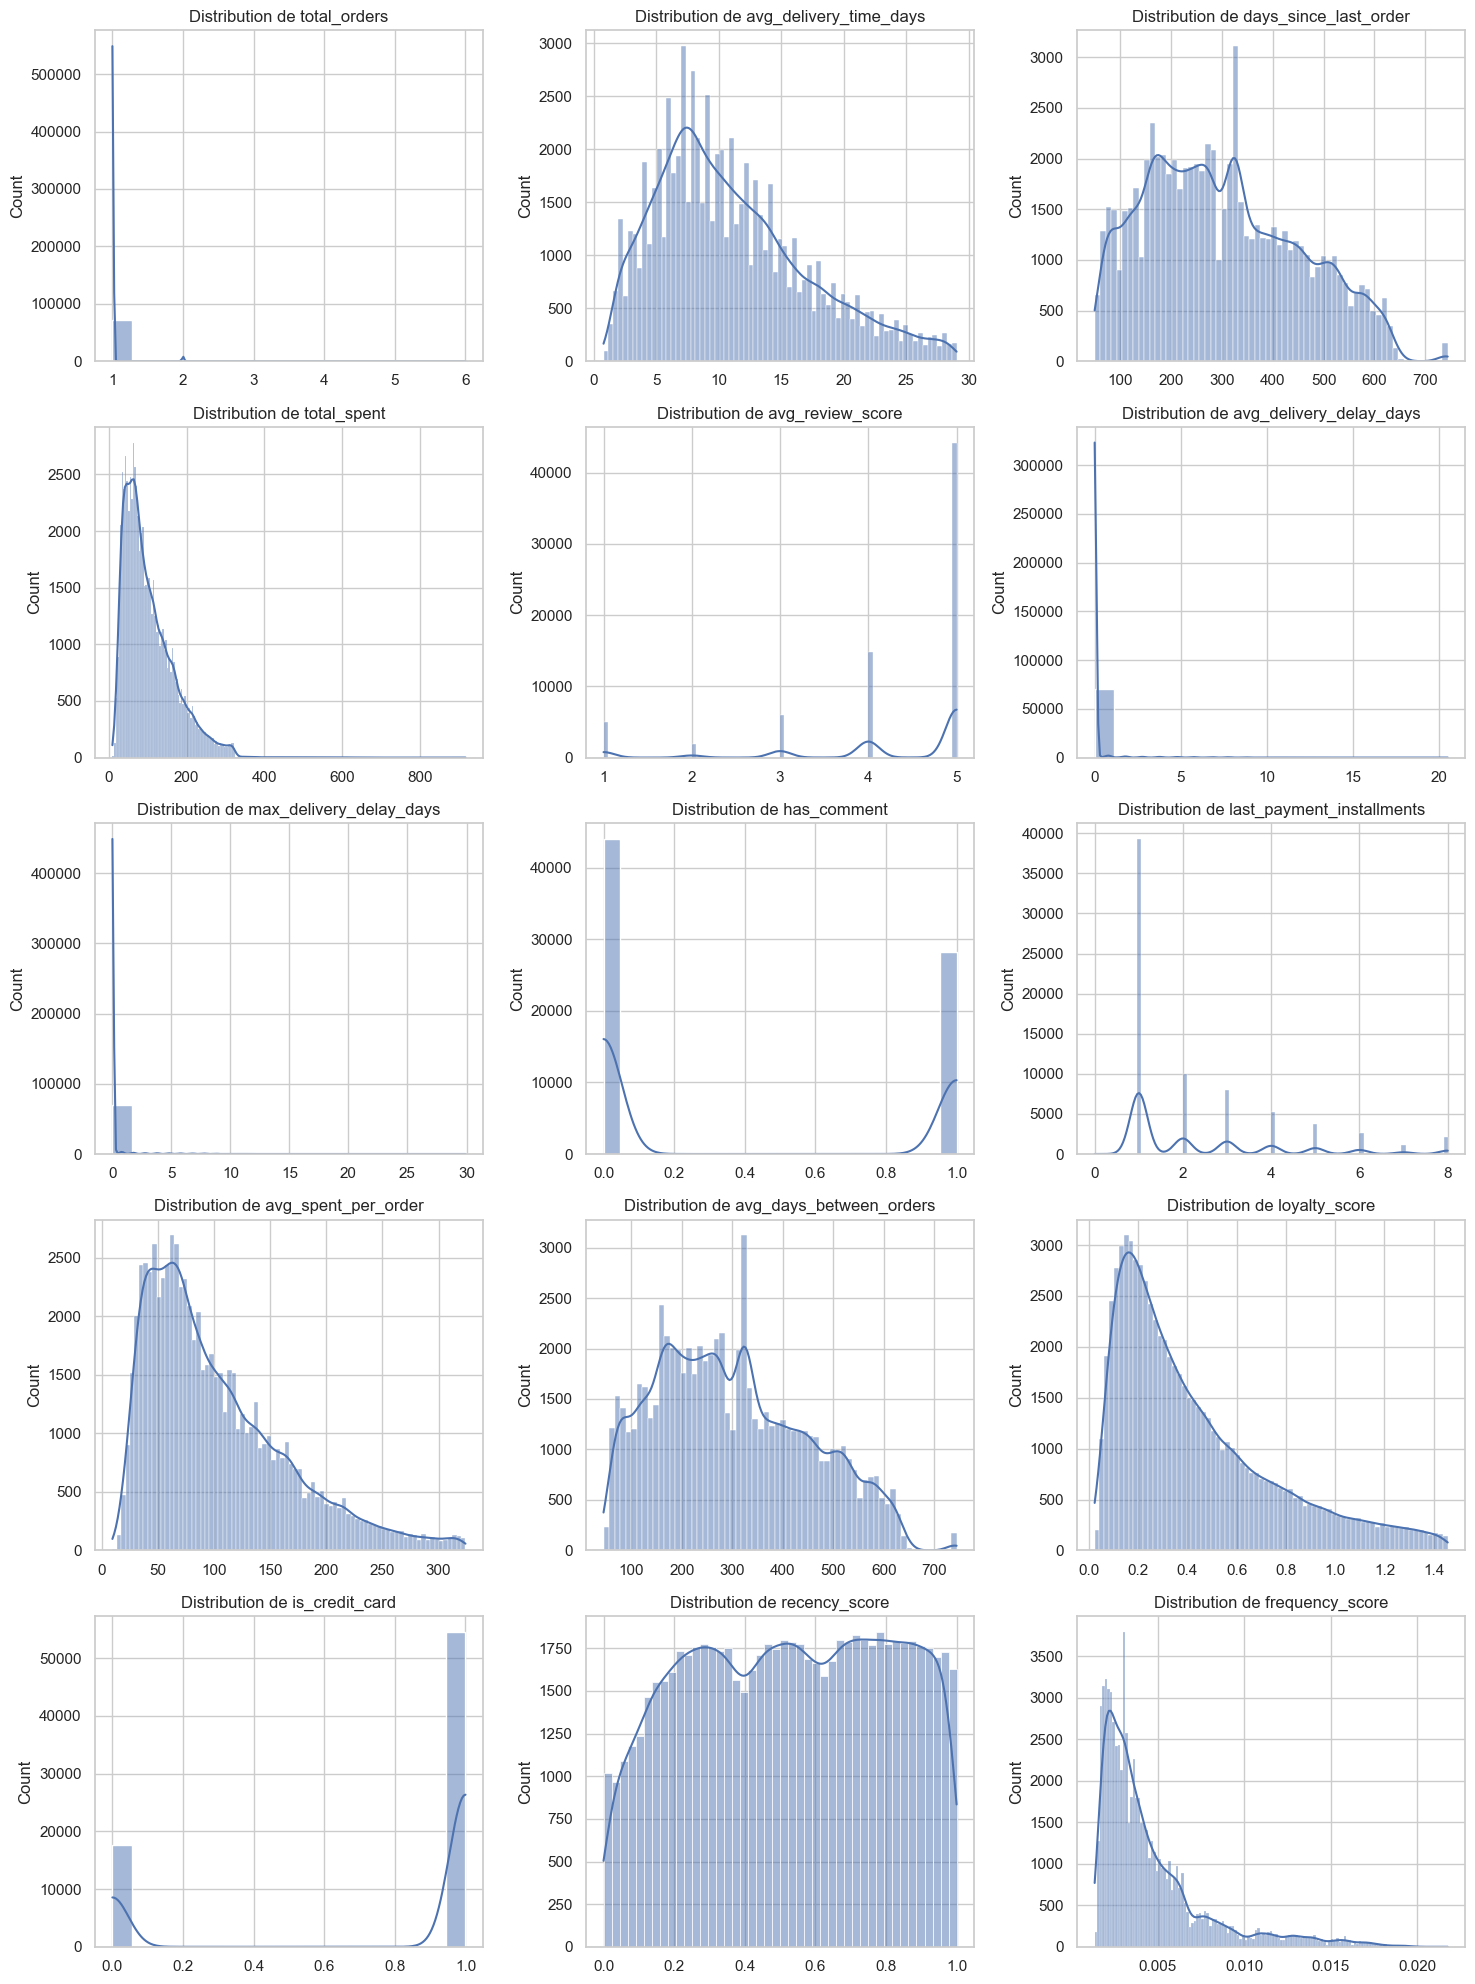

In [21]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Nombre total de graphiques à tracer
num_plots = len(numeric_columns)
# Définir le nombre de colonnes souhaité, par exemple 3
num_cols = 3
# Calculer le nombre de lignes nécessaires
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
axes = axes.flatten()  # Mettre tous les axes dans un tableau 1D

for idx, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution de {col}')
    axes[idx].set_xlabel('')

# Supprimer les axes inutilisés
for ax in axes[num_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [22]:
# # Les colonnes max_delivery_delay_days et avg_delivery_delay_days contiennent des valeurs identiques. Nous le vérifions, et si c'est le cas, supprimons une des colonnes.
# print("Les colonnes max_delivery_delay_days et avg_delivery_delay_days contiennent-elles les mêmes valeurs ?")
# sameValues = (df['max_delivery_delay_days'] == df['avg_delivery_delay_days']).all()

# # quelles sont les valeurs différentes entre les deux colonnes ?
# if not sameValues:
#     print("Les colonnes max_delivery_delay_days et avg_delivery_delay_days ne contiennent pas les mêmes valeurs.")
#     print("Valeurs différentes entre les deux colonnes :")
#     print(df.loc[df['max_delivery_delay_days'] != df['avg_delivery_delay_days'], ['max_delivery_delay_days', 'avg_delivery_delay_days']])

# # Suppression de la colonne avg_delivery_delay_days
# if sameValues:
#     print("Les colonnes max_delivery_delay_days et avg_delivery_delay_days contiennent les mêmes valeurs. Nous allons supprimer la colonne avg_delivery delay_days.")
#     df = df.drop(columns=['avg_delivery_delay_days'])
#     numeric_columns = numeric_columns.drop('avg_delivery_delay_days')

In [23]:
# Il n'y a que 188 cas où la valeur est différente. Nous supprimons la colonne avg_delivery_delay_days.
# df = df.drop(columns=['avg_delivery_delay_days'])

# on enlève avg_delivery_delay_days de numeric_columns

### Analyse des outliers

Nous pouvons observer que certaines variables comme 'total_orders', 'total_spent', et 'max_delivery_delay_days' présentent des valeurs extrêmes. Ces outliers peuvent être légitimes dans le contexte d'un site e-commerce (par exemple, des clients très fidèles ou des commandes très importantes), mais il faudra les prendre en compte lors de la modélisation.

## 4. Analyse des variables catégorielles

In [24]:
# Sélection des colonnes catégorielles
categorical_columns = df.select_dtypes(exclude=['number']).columns
print("Colonnes catégorielles :")
print(categorical_columns)

# Affichage des valeurs uniques pour chaque variable catégorielle
for col in categorical_columns:
    # Seulement si ce n'est pas customer_unique_id
    if col == 'customer_unique_id':
        continue
    print(f"\nValeurs uniques dans {col}:")
    print(df[col].value_counts())

Colonnes catégorielles :
Index(['customer_unique_id', 'last_order_status', 'last_payment_type'], dtype='object')

Valeurs uniques dans last_order_status:
last_order_status
delivered    72310
canceled         3
Name: count, dtype: int64

Valeurs uniques dans last_payment_type:
last_payment_type
credit_card    54591
boleto         15319
voucher         1289
debit_card      1114
Name: count, dtype: int64


In [25]:
# La colonne "last_order_status" ne contient qu'une seule valeur à l'exception de 6 individus, on la supprime
df = df.drop(columns=['last_order_status'])

In [26]:
# La colonne "last_payment_type" contient une majorité de "credit_card". Nous allons utiliser 2 valeurs pour cette colonne, credit_card et other
df['last_payment_type'] = df['last_payment_type'].apply(lambda x: 'credit_card' if x == 'credit_card' else 'other')

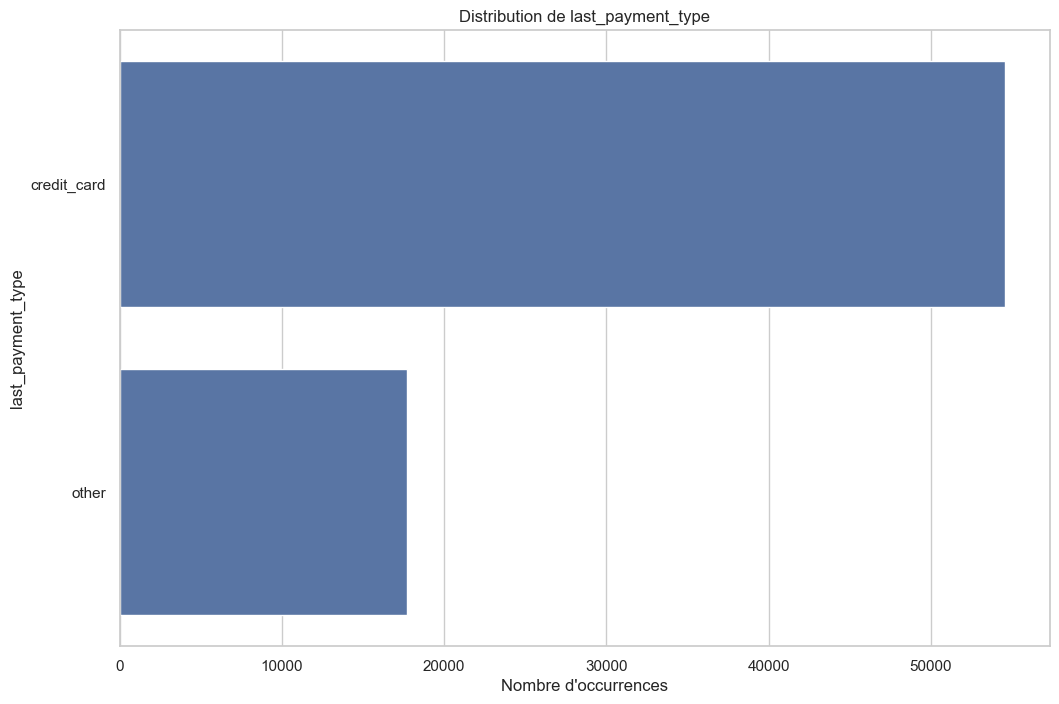

In [27]:
# Colonnes catégorielles sans customer_unique_id
categorical_columns = categorical_columns.drop(['customer_unique_id', 'last_order_status'])

# # Visualisation de la distribution de la variable catégorielle "last_payment_type"
sns.countplot(y=df['last_payment_type'])
plt.title('Distribution de last_payment_type')
plt.xlabel('Nombre d\'occurrences')
plt.show()


# fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(12, 6*len(categorical_columns)))

# for idx, col in enumerate(categorical_columns):
#     sns.countplot(y=df[col], ax=axes[idx])
#     axes[idx].set_title(f'Distribution de {col}')
#     axes[idx].set_xlabel('Nombre d\'occurrences')

# plt.tight_layout()
# plt.show()

## 5. Analyse des corrélations

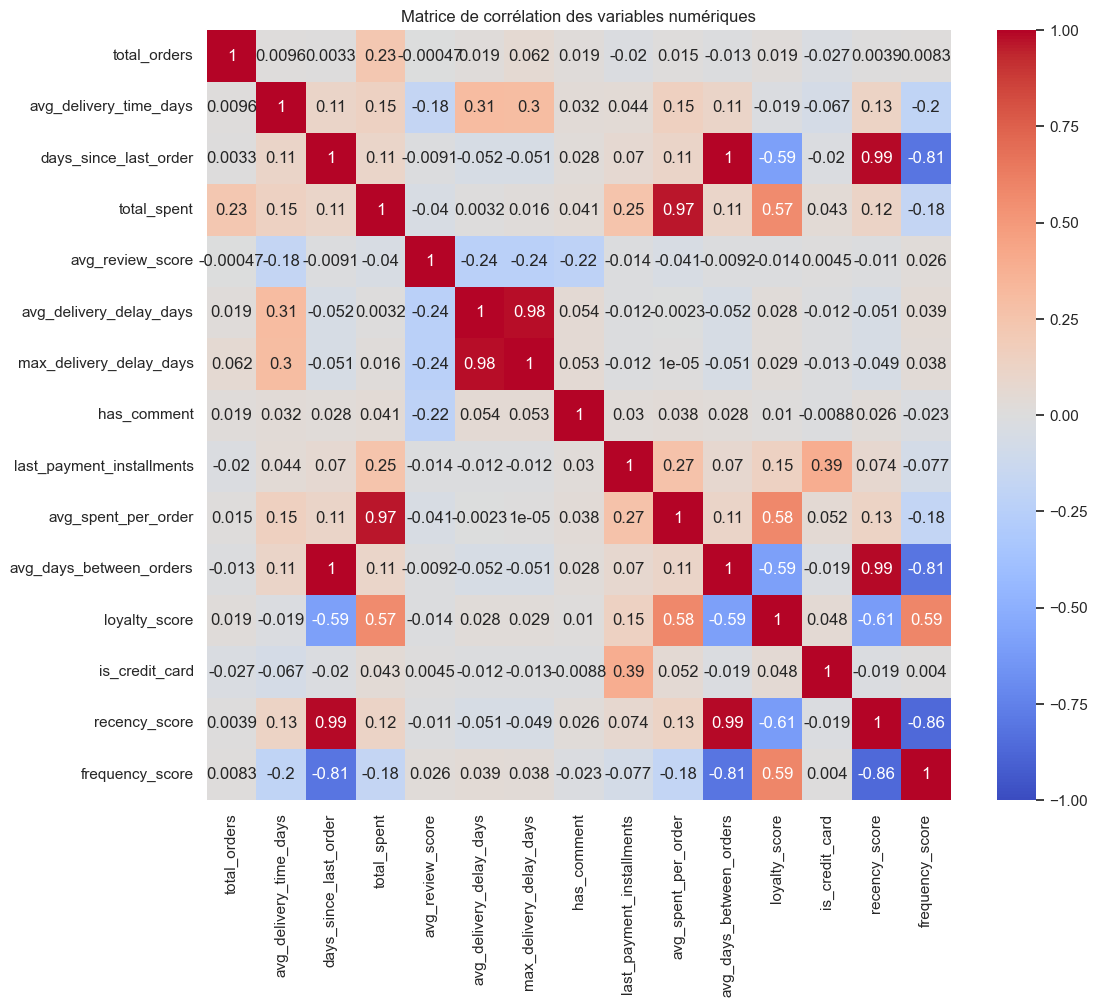

La matrice de corrélation a été sauvegardée dans 'data/correlation_matrix.csv'


In [28]:
# Calcul de la matrice de corrélation
correlation_matrix = df[numeric_columns].corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice de corrélation des variables numériques')
plt.show()

# Sauvegarde de la matrice de corrélation
correlation_matrix.to_csv('data/correlation_matrix.csv')
print("La matrice de corrélation a été sauvegardée dans 'data/correlation_matrix.csv'")

In [29]:
df.sample(10)

,customer_unique_id,total_orders,avg_delivery_time_days,days_since_last_order,total_spent,avg_review_score,avg_delivery_delay_days,max_delivery_delay_days,has_comment,last_payment_type,last_payment_installments,avg_spent_per_order,avg_days_between_orders,loyalty_score,is_credit_card,recency_score,frequency_score
64214,a915c8d4e27f573bb89c9bac9064290d,1,14.724850,414.684838,31.38,4.0,0.000000,0.000000,0,credit_card,2.0,31.38,414.684838,0.075490,1,0.773193,0.002406
77611,cc70d5aa7dd1a57edcac67386095531e,1,3.826782,317.889306,154.77,1.0,0.000000,0.000000,1,credit_card,7.0,154.77,317.889306,0.485341,1,0.597437,0.003136
7324,132bcd02d6f963e0199a9dc66e881fd1,1,12.821123,516.906076,78.17,3.0,0.686088,0.686088,1,other,1.0,78.17,516.906076,0.150935,0,0.899607,0.001931
94378,f8bdf9eddb52e5499f3c2bfbb498679e,1,13.110162,445.035394,46.37,5.0,0.000000,0.000000,0,other,1.0,46.37,445.035394,0.103960,0,0.814737,0.002242
16177,2aa6299511b1833e92e3ecae00a3d79e,1,6.134317,94.855579,64.55,5.0,0.000000,0.000000,0,credit_card,1.0,64.55,94.855579,0.673409,1,0.107841,0.010432
45237,771f344c1ac13d8ccdf2d14c48e2c6c3,1,1.984977,454.913090,38.11,5.0,0.000000,0.000000,0,other,1.0,38.11,454.913090,0.083590,0,0.827201,0.002193
80123,d2f122bc3109d7fb2385daec2d6ef7f7,1,5.397118,458.335104,113.62,4.0,0.000000,0.000000,0,credit_card,1.0,113.62,458.335104,0.247358,1,0.832969,0.002177
1937,05105abc98016eb044d450d5e60de1b2,1,3.373345,435.295822,65.17,5.0,0.000000,0.000000,0,credit_card,2.0,65.17,435.295822,0.149371,1,0.801438,0.002292
56728,95ae9ff17e664d7e83d3d685e78935da,1,19.012627,511.346424,144.47,5.0,0.000000,0.000000,1,other,1.0,144.47,511.346424,0.281977,0,0.892725,0.001952
84160,dd9b099cb7a885347fee971bf22ea6d5,1,2.958773,211.829780,82.51,4.0,0.000000,0.000000,1,other,1.0,82.51,211.829780,0.387681,0,0.361215,0.004699


### Analyse des corrélations

On peut observer quelques corrélations intéressantes :
1. Une forte corrélation positive entre 'total_orders' et 'total_spent', ce qui est logique.
2. Une corrélation modérée entre 'avg_delivery_time_days' et 'avg_delivery_delay_days', ce qui suggère que les retards de livraison contribuent significativement au temps de livraison total.
3. Une faible corrélation négative entre 'avg_review_score' et 'avg_delivery_delay_days', indiquant que les retards de livraison peuvent légèrement impacter la satisfaction client.

Ces corrélations seront importantes à considérer lors de la phase de modélisation pour éviter la multicolinéarité et pour choisir les variables les plus pertinentes pour la segmentation.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72313 entries, 0 to 97077
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         72313 non-null  object 
 1   total_orders               72313 non-null  int64  
 2   avg_delivery_time_days     72313 non-null  float64
 3   days_since_last_order      72313 non-null  float64
 4   total_spent                72313 non-null  float64
 5   avg_review_score           72313 non-null  float64
 6   avg_delivery_delay_days    72313 non-null  float64
 7   max_delivery_delay_days    72313 non-null  float64
 8   has_comment                72313 non-null  int64  
 9   last_payment_type          72313 non-null  object 
 10  last_payment_installments  72313 non-null  float64
 11  avg_spent_per_order        72313 non-null  float64
 12  avg_days_between_orders    72313 non-null  float64
 13  loyalty_score              72313 non-null  float64


# 9. Conclusion et prochaines étapes

"""
### Résumé de l'analyse exploratoire

1. **Données initiales** : Nous avons analysé un jeu de données de 97078 clients d'un site e-commerce, comprenant diverses variables comportementales et transactionnelles.

2. **Préparation des données** :
   - Traitement des valeurs manquantes
   - Suppression des outliers sur les variables clés
   - Simplification des variables catégorielles
   - Feature engineering pour créer des variables plus pertinentes

3. **Variables importantes** :
   - La majorité des clients ont effectué une seule commande
   - Les délais de livraison varient considérablement
   - La satisfaction client (review score) est généralement élevée
   - Les modes de paiement sont dominés par la carte de crédit

4. **Corrélations notables** :
   - Lien entre temps de livraison et satisfaction client
   - Corrélation entre méthode de paiement et montant dépensé
   - Lien entre fréquence d'achat et fidélité

### Prochaines étapes

1. **Modélisation** :
   - Standardisation des variables numériques
   - Application d'algorithmes de clustering (K-means, DBSCAN)
   - Analyse RFM (Récence, Fréquence, Montant)

2. **Segmentation** :
   - Détermination du nombre optimal de segments
   - Caractérisation des segments de clients
   - Validation de la pertinence business des segments

3. **Exploitation** :
   - Développement de stratégies marketing personnalisées par segment
   - Mise en place d'un suivi de l'évolution des segments dans le temps
   - Optimisation des parcours client en fonction des segments

Le dataset nettoyé et augmenté servira de base solide pour la phase de segmentation.
"""

In [31]:
# 8. Préparation du dataset final

# Vérifions qu'il n'y a plus de valeurs manquantes
missing_values = df.isnull().sum()
print("Vérification des valeurs manquantes dans le dataset:")
display(missing_values[missing_values > 0])

# Si nécessaire, supprimons les observations avec des valeurs manquantes
if missing_values.sum() > 0:
    df = df.dropna()
    print(f"Après suppression des valeurs manquantes, nous avons {df.shape[0]} observations.")

# Simplifions la colonne "last_payment_type" en catégories plus pertinentes
df['last_payment_type'] = df['last_payment_type'].apply(lambda x: 'credit_card' if x == 'credit_card' else 'other')

# Supprimons les colonnes inutiles ou redondantes
# - total_orders et total_spent sont déjà représentés par avg_spent_per_order
# - last_order_date est déjà représentée par days_since_last_order
# - max_delivery_delay_days et avg_delivery_delay_days sont très corrélées, nous gardons max_delivery_delay_days
columns_to_drop = ['total_orders', 'total_spent', 'last_order_date']
if 'avg_delivery_delay_days' in df.columns and 'max_delivery_delay_days' in df.columns:
    # Vérifions si les colonnes sont identiques
    if (df['avg_delivery_delay_days'] == df['max_delivery_delay_days']).all():
        columns_to_drop.append('avg_delivery_delay_days')
    else:
        print("Les colonnes avg_delivery_delay_days et max_delivery_delay_days ne sont pas identiques.")
        print("Gardons les deux colonnes pour plus de précision.")

# Suppression des colonnes inutiles
df = df.drop(columns=columns_to_drop, errors='ignore')
print(f"\nLe dataset final contient {df.shape[0]} observations et {df.shape[1]} variables.")

# Affichage de la structure du dataset final
print("\nStructure du dataset final:")
df.info()

# Exporter le dataset nettoyé
df.to_csv('data/clean.csv', index=False)
print("\nLe dataset nettoyé a été sauvegardé dans 'data/clean.csv'")

# Affichage d'un échantillon du dataset final
print("\nAperçu du dataset final:")
display(df.sample(5))

Vérification des valeurs manquantes dans le dataset:


Series([], dtype: int64)

Les colonnes avg_delivery_delay_days et max_delivery_delay_days ne sont pas identiques.
Gardons les deux colonnes pour plus de précision.

Le dataset final contient 72313 observations et 15 variables.

Structure du dataset final:
<class 'pandas.core.frame.DataFrame'>
Index: 72313 entries, 0 to 97077
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         72313 non-null  object 
 1   avg_delivery_time_days     72313 non-null  float64
 2   days_since_last_order      72313 non-null  float64
 3   avg_review_score           72313 non-null  float64
 4   avg_delivery_delay_days    72313 non-null  float64
 5   max_delivery_delay_days    72313 non-null  float64
 6   has_comment                72313 non-null  int64  
 7   last_payment_type          72313 non-null  object 
 8   last_payment_installments  72313 non-null  float64
 9   avg_spent_per_order        72313 non-null  fl

,customer_unique_id,avg_delivery_time_days,days_since_last_order,avg_review_score,avg_delivery_delay_days,max_delivery_delay_days,has_comment,last_payment_type,last_payment_installments,avg_spent_per_order,avg_days_between_orders,loyalty_score,is_credit_card,recency_score,frequency_score
55960,93b305948f8ecf70d2248fb41e0bce89,19.002176,395.034734,5.0,0.0,0.0,1,credit_card,6.0,125.53,395.034734,0.316967,1,0.744607,0.002525
76421,c9439890f84d87ff0eca5ce638cc92da,16.935336,303.014294,5.0,0.0,0.0,0,other,1.0,273.20,303.014294,0.898642,0,0.564402,0.003289
29039,4c7ce7066ceda7a26b953bf1b47d09f7,13.046840,270.159711,5.0,0.0,0.0,0,other,1.0,99.33,270.159711,0.366315,0,0.500659,0.003688
17028,2cd3acc4a3c71ee64088dfce1e16ba58,4.531493,248.712431,5.0,0.0,0.0,1,credit_card,2.0,47.68,248.712431,0.190940,1,0.451256,0.004005
82085,d83533715a8843e3a26adf36d889e9b7,7.932442,527.080023,5.0,0.0,0.0,0,credit_card,6.0,126.39,527.080023,0.239339,1,0.912297,0.001894


In [32]:
# Génération du fichier csv clean pour les modèles de machine learning
df.to_csv('data/clean.csv', index=False)
print("Le dataset nettoyé a été sauvegardé dans 'data/clean.csv'")

# Affichage d'un échantillon du dataset final
df.sample(10)

Le dataset nettoyé a été sauvegardé dans 'data/clean.csv'


,customer_unique_id,avg_delivery_time_days,days_since_last_order,avg_review_score,avg_delivery_delay_days,max_delivery_delay_days,has_comment,last_payment_type,last_payment_installments,avg_spent_per_order,avg_days_between_orders,loyalty_score,is_credit_card,recency_score,frequency_score
45226,77181aad9f3070ba90488e6bbb045f1f,16.793877,227.663866,5.0,0.0,0.0,0,credit_card,1.0,88.06,227.663866,0.385107,1,0.399164,0.004373
16281,2ae5e18bcb19f806865d414e74bfa11e,2.123924,133.011771,5.0,0.0,0.0,1,credit_card,1.0,48.87,133.011771,0.364669,1,0.181967,0.007462
64924,aaeeb65a60e52a95bcca22d97211f25f,4.083380,208.366273,5.0,0.0,0.0,1,credit_card,1.0,32.29,208.366273,0.154227,1,0.352181,0.004776
17133,2d178f990a941521701a798ea92d9a11,4.661076,219.372824,5.0,0.0,0.0,1,other,1.0,189.56,219.372824,0.860179,0,0.379911,0.004538
62505,a4a1e0a2d4e1466898d4f819ecf3958c,8.845417,568.943113,3.0,0.0,0.0,0,other,1.0,67.74,568.943113,0.118854,0,0.948670,0.001755
35343,5cd3689c4b395fa5f5fced6b50294a0f,13.010891,266.897616,5.0,0.0,0.0,0,credit_card,1.0,41.71,266.897616,0.155694,1,0.492120,0.003733
78844,cfc6b57f63e26d893f225263009fc719,11.319444,167.248056,5.0,0.0,0.0,0,credit_card,3.0,162.41,167.248056,0.965301,1,0.256629,0.005944
77130,cb2d0feeee92a4f519b0c74f336dbc5e,6.833704,309.029167,4.0,0.0,0.0,1,credit_card,5.0,149.69,309.029167,0.482826,1,0.575733,0.003226
52821,8b4dfb33600fe0ac926b19b31aaeb8e8,6.101019,132.973148,4.0,0.0,0.0,1,other,1.0,44.72,132.973148,0.333798,0,0.181864,0.007464
61489,a20c851e6434f1e7b943de9d1c2956d6,18.198021,369.146771,2.0,0.0,0.0,0,credit_card,2.0,116.94,369.146771,0.315929,1,0.707019,0.002702
